In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from collections import Counter
from tqdm import tqdm
import importlib

import sys
sys.path.append(str(Path().resolve()))
import src.models.recsys_models as recsys_models
importlib.reload(recsys_models)

from src.models.recsys_models import GRU4Rec, SessionDataset, create_dataloader 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

DATA_DIR = Path("data/processed")


Using device: cpu


In [135]:
import os
os.getcwd() # Working directory should be in the project folder.

'c:\\Users\\Mohammad\\Desktop\\Hands-On Projects\\Recommendation System\\Session-Based Sequential Recommender (GRU4Rec  Transformer)'

In [108]:
X_train = np.load(DATA_DIR / "X_train.npy")
y_train = np.load(DATA_DIR / "y_train.npy")
L_train = np.load(DATA_DIR / "L_train.npy")

X_val = np.load(DATA_DIR / "X_val.npy")
y_val = np.load(DATA_DIR / "y_val.npy")
L_val = np.load(DATA_DIR / "L_val.npy")

X_test = np.load(DATA_DIR / "X_test.npy")
y_test = np.load(DATA_DIR / "y_test.npy")
L_test = np.load(DATA_DIR / "L_test.npy")

item2idx = np.load(DATA_DIR / "item2idx.npy", allow_pickle=True).item()
num_items = len(item2idx)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:  ", X_val.shape, y_val.shape)
print("Test shape: ", X_test.shape, y_test.shape)
print("Num items:  ", num_items)


Train shape: (149861, 50) (149861,)
Val shape:   (18733, 50) (18733,)
Test shape:  (18733, 50) (18733,)
Num items:   19411


In [109]:
batch_size = 256

train_loader = create_dataloader(X_train, y_train, L_train, batch_size=batch_size, shuffle=True)
val_loader   = create_dataloader(X_val,   y_val,   L_val,   batch_size=batch_size, shuffle=False)
test_loader  = create_dataloader(X_test,  y_test,  L_test,  batch_size=512,       shuffle=False)


In [110]:
def recall_mrr_at_k(model, dataloader, ks=(10, 20), device=DEVICE):
    model.eval()
    ks = sorted(ks)
    recalls = {k: 0 for k in ks}
    mrrs = {k: 0.0 for k in ks}
    n = 0

    with torch.no_grad():
        for x, y, lengths in dataloader:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            logits = model(x, lengths)  # (B, num_items+1)
            max_k = max(ks)
            _, ranked = torch.topk(logits, k=max_k, dim=1)

            for i in range(x.size(0)):
                true_item = y[i].item()
                preds = ranked[i].cpu().tolist()
                n += 1
                for k in ks:
                    topk = preds[:k]
                    if true_item in topk:
                        recalls[k] += 1
                        rank = topk.index(true_item) + 1
                        mrrs[k] += 1.0 / rank

    recalls = {k: recalls[k] / n for k in ks}
    mrrs = {k: mrrs[k] / n for k in ks}
    return recalls, mrrs


In [124]:
def train_model(
    model_name,
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=1e-3,
    weight_decay=1e-5,
    scheduler_step=5,
    scheduler_gamma=0.5,
    device=DEVICE,
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_recall@10": [],
        "val_recall@20": [],
        "val_mrr@10": [],
        "val_mrr@20": [],
    }

    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_count = 0

        pbar = tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch}/{num_epochs}")
        for x, y, lengths in pbar:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)

            optimizer.zero_grad()
            logits = model(x, lengths)

            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            bs = x.size(0)
            total_loss += loss.item() * bs
            total_count += bs

            pbar.set_postfix({"loss": total_loss / total_count})

        train_loss = total_loss / total_count

        # Evaluate on validation set
        val_loss = 0.0
        val_count = 0
        model.eval()
        with torch.no_grad():
            for x, y, lengths in val_loader:
                x, y, lengths = x.to(device), y.to(device), lengths.to(device)
                logits = model(x, lengths)
                loss = criterion(logits, y)
                bs = x.size(0)
                val_loss += loss.item() * bs
                val_count += bs

        val_loss /= val_count
        recalls, mrrs = recall_mrr_at_k(model, val_loader, ks=(10, 20), device=device)

        print(
            f"[{model_name}] Epoch {epoch}: "
            f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
            f"R@10={recalls[10]:.4f}, R@20={recalls[20]:.4f}, "
            f"MRR@10={mrrs[10]:.4f}, MRR@20={mrrs[20]:.4f}"
        )

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_recall@10"].append(recalls[10])
        history["val_recall@20"].append(recalls[20])
        history["val_mrr@10"].append(mrrs[10])
        history["val_mrr@20"].append(mrrs[20])

        # Save best on val_loss (optional)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # optional: save model state here if you want
            # torch.save(model.state_dict(), f"models/{model_name}_best.pt")

        scheduler.step()

    return history, model


In [125]:
experiment_configs = {
    "GRU_small": {
        "embedding_dim": 64,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.0,
        "epochs": 10,
    },
    "GRU_medium": {
        "embedding_dim": 128,
        "hidden_dim": 256,
        "num_layers": 2,
        "dropout": 0.2,
        "epochs": 15,
    },
    "GRU_large": {
        "embedding_dim": 256,
        "hidden_dim": 512,
        "num_layers": 2,
        "dropout": 0.3,
        "epochs": 20,
    },
}

def build_gru_model(name, num_items):
    cfg = experiment_configs[name]
    # model = nn.Sequential()  # placeholder to keep local logic consistent (we won't use Sequential directly)
    # # We’ll create GRU4Rec with extended constructor below
    # class GRU4RecExtended(GRU4Rec):
    #     def __init__(self, num_items, embedding_dim, hidden_dim, num_layers, dropout):
    #         super().__init__(num_items, embedding_dim=embedding_dim, hidden_dim=hidden_dim, padding_idx=0)
    #         # override GRU with custom num_layers and dropout
    #         self.gru = nn.GRU(
    #             input_size=embedding_dim,
    #             hidden_size=hidden_dim,
    #             num_layers=num_layers,
    #             batch_first=True,
    #             dropout=dropout if num_layers > 1 else 0.0, # Only used for multilayers.
    #         )

    return GRU4Rec(
        num_items=num_items,
        embedding_dim=cfg["embedding_dim"],
        hidden_dim=cfg["hidden_dim"],
        num_layers=cfg["num_layers"],
        dropout=cfg["dropout"],
        padding_idx=0,
    )


In [126]:

def most_popular_baseline(y_train, y_true, ks=(10, 20)):
    # count frequencies of items in train labels
    counts = Counter(y_train.tolist())
    # most common items
    popular_items = [item for item, _ in counts.most_common(max(ks))]

    recalls = {k: 0 for k in ks}
    mrrs = {k: 0.0 for k in ks}
    n = len(y_true)

    for true_item in y_true:
        true_item = int(true_item)
        for k in ks:
            topk = popular_items[:k]
            if true_item in topk:
                recalls[k] += 1
                rank = topk.index(true_item) + 1
                mrrs[k] += 1.0 / rank

    recalls = {k: recalls[k] / n for k in ks}
    mrrs = {k: mrrs[k] / n for k in ks}
    return recalls, mrrs

mp_recalls, mp_mrrs = most_popular_baseline(y_train, y_test, ks=(10, 20))
print("Most Popular baseline - Recall:", mp_recalls)
print("Most Popular baseline - MRR:", mp_mrrs)


Most Popular baseline - Recall: {10: 0.07372017295681418, 20: 0.1142369081300379}
Most Popular baseline - MRR: {10: 0.025722305684137782, 20: 0.028488164403480863}


In [127]:
experiment_configs

{'GRU_small': {'embedding_dim': 64,
  'hidden_dim': 128,
  'num_layers': 1,
  'dropout': 0.0,
  'epochs': 10},
 'GRU_medium': {'embedding_dim': 128,
  'hidden_dim': 256,
  'num_layers': 2,
  'dropout': 0.2,
  'epochs': 15},
 'GRU_large': {'embedding_dim': 256,
  'hidden_dim': 512,
  'num_layers': 2,
  'dropout': 0.3,
  'epochs': 20}}

In [ ]:
all_histories = {}
final_results = []

for name, cfg in experiment_configs.items():
    print(f"\n------- Training {name} ------")
    model = build_gru_model(name, num_items)

    history, trained_model = train_model(
        model_name=name,
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=cfg["epochs"],
        lr=1e-3,
        weight_decay=1e-5,
        scheduler_step=5,
        scheduler_gamma=0.5,
    )

    all_histories[name] = history

    # Evaluate on test set
    test_recalls, test_mrrs = recall_mrr_at_k(trained_model, test_loader, ks=(10, 20), device=DEVICE)
    final_results.append({
        "model": name,
        "R@10": f"{test_recalls[10]:.5f}",
        "R@20": f"{test_recalls[20]:.5f}",
        "MRR@10": f"{test_mrrs[10]:.5f}",
        "MRR@20": f"{test_mrrs[20]:.5f}",
    })

final_results_df = pd.DataFrame(final_results)
final_results_df



------- Training GRU_small ------


[GRU_small] Epoch 1/10:   0%|          | 0/586 [00:00<?, ?it/s]

[GRU_small] Epoch 1/10: 100%|██████████| 586/586 [00:41<00:00, 14.23it/s, loss=8.11]


[GRU_small] Epoch 1: train_loss=8.1103, val_loss=7.7640, R@10=0.0717, R@20=0.1140, MRR@10=0.0272, MRR@20=0.0301


[GRU_small] Epoch 2/10: 100%|██████████| 586/586 [00:41<00:00, 14.27it/s, loss=7.69]


[GRU_small] Epoch 2: train_loss=7.6894, val_loss=7.7640, R@10=0.0713, R@20=0.1131, MRR@10=0.0272, MRR@20=0.0300


[GRU_small] Epoch 3/10: 100%|██████████| 586/586 [00:45<00:00, 12.98it/s, loss=7.67]


[GRU_small] Epoch 3: train_loss=7.6665, val_loss=7.7700, R@10=0.0728, R@20=0.1135, MRR@10=0.0272, MRR@20=0.0300


[GRU_small] Epoch 4/10: 100%|██████████| 586/586 [00:41<00:00, 14.20it/s, loss=7.65]


[GRU_small] Epoch 4: train_loss=7.6462, val_loss=7.7803, R@10=0.0698, R@20=0.1129, MRR@10=0.0257, MRR@20=0.0287


[GRU_small] Epoch 5/10: 100%|██████████| 586/586 [00:41<00:00, 14.09it/s, loss=7.63]


[GRU_small] Epoch 5: train_loss=7.6263, val_loss=7.7888, R@10=0.0703, R@20=0.1128, MRR@10=0.0267, MRR@20=0.0296


[GRU_small] Epoch 6/10: 100%|██████████| 586/586 [00:43<00:00, 13.51it/s, loss=7.57]


[GRU_small] Epoch 6: train_loss=7.5688, val_loss=7.8049, R@10=0.0697, R@20=0.1125, MRR@10=0.0266, MRR@20=0.0296


[GRU_small] Epoch 7/10: 100%|██████████| 586/586 [00:42<00:00, 13.66it/s, loss=7.55]


[GRU_small] Epoch 7: train_loss=7.5525, val_loss=7.8114, R@10=0.0706, R@20=0.1125, MRR@10=0.0270, MRR@20=0.0298


[GRU_small] Epoch 8/10: 100%|██████████| 586/586 [00:43<00:00, 13.46it/s, loss=7.54]


[GRU_small] Epoch 8: train_loss=7.5377, val_loss=7.8232, R@10=0.0728, R@20=0.1123, MRR@10=0.0270, MRR@20=0.0297


[GRU_small] Epoch 9/10: 100%|██████████| 586/586 [00:46<00:00, 12.68it/s, loss=7.52]


[GRU_small] Epoch 9: train_loss=7.5247, val_loss=7.8301, R@10=0.0713, R@20=0.1125, MRR@10=0.0268, MRR@20=0.0297


[GRU_small] Epoch 10/10: 100%|██████████| 586/586 [00:46<00:00, 12.72it/s, loss=7.51]


[GRU_small] Epoch 10: train_loss=7.5121, val_loss=7.8390, R@10=0.0723, R@20=0.1134, MRR@10=0.0267, MRR@20=0.0295

------- Training GRU_medium ------


[GRU_medium] Epoch 1/15: 100%|██████████| 586/586 [01:36<00:00,  6.05it/s, loss=7.94]


[GRU_medium] Epoch 1: train_loss=7.9388, val_loss=7.7691, R@10=0.0705, R@20=0.1130, MRR@10=0.0270, MRR@20=0.0299


[GRU_medium] Epoch 2/15: 100%|██████████| 586/586 [01:37<00:00,  6.02it/s, loss=7.69]


[GRU_medium] Epoch 2: train_loss=7.6892, val_loss=7.7815, R@10=0.0703, R@20=0.1108, MRR@10=0.0264, MRR@20=0.0291


[GRU_medium] Epoch 3/15: 100%|██████████| 586/586 [01:37<00:00,  6.00it/s, loss=7.66]


[GRU_medium] Epoch 3: train_loss=7.6617, val_loss=7.7830, R@10=0.0730, R@20=0.1140, MRR@10=0.0272, MRR@20=0.0299


[GRU_medium] Epoch 4/15: 100%|██████████| 586/586 [01:39<00:00,  5.92it/s, loss=7.63]


[GRU_medium] Epoch 4: train_loss=7.6338, val_loss=7.7932, R@10=0.0721, R@20=0.1150, MRR@10=0.0268, MRR@20=0.0297


[GRU_medium] Epoch 5/15: 100%|██████████| 586/586 [01:37<00:00,  5.98it/s, loss=7.61]


[GRU_medium] Epoch 5: train_loss=7.6060, val_loss=7.8080, R@10=0.0690, R@20=0.1125, MRR@10=0.0266, MRR@20=0.0296


[GRU_medium] Epoch 6/15: 100%|██████████| 586/586 [01:34<00:00,  6.23it/s, loss=7.54]


[GRU_medium] Epoch 6: train_loss=7.5418, val_loss=7.8188, R@10=0.0710, R@20=0.1127, MRR@10=0.0269, MRR@20=0.0298


[GRU_medium] Epoch 7/15: 100%|██████████| 586/586 [01:31<00:00,  6.37it/s, loss=7.53]


[GRU_medium] Epoch 7: train_loss=7.5253, val_loss=7.8302, R@10=0.0711, R@20=0.1123, MRR@10=0.0267, MRR@20=0.0294


[GRU_medium] Epoch 8/15: 100%|██████████| 586/586 [01:32<00:00,  6.34it/s, loss=7.51]


[GRU_medium] Epoch 8: train_loss=7.5111, val_loss=7.8379, R@10=0.0721, R@20=0.1124, MRR@10=0.0271, MRR@20=0.0298


[GRU_medium] Epoch 9/15: 100%|██████████| 586/586 [01:32<00:00,  6.34it/s, loss=7.5] 


[GRU_medium] Epoch 9: train_loss=7.4976, val_loss=7.8449, R@10=0.0708, R@20=0.1123, MRR@10=0.0268, MRR@20=0.0296


[GRU_medium] Epoch 10/15: 100%|██████████| 586/586 [01:33<00:00,  6.28it/s, loss=7.49]


[GRU_medium] Epoch 10: train_loss=7.4853, val_loss=7.8579, R@10=0.0692, R@20=0.1110, MRR@10=0.0263, MRR@20=0.0292


[GRU_medium] Epoch 11/15: 100%|██████████| 586/586 [01:32<00:00,  6.36it/s, loss=7.44]


[GRU_medium] Epoch 11: train_loss=7.4445, val_loss=7.8623, R@10=0.0712, R@20=0.1121, MRR@10=0.0268, MRR@20=0.0296


[GRU_medium] Epoch 12/15: 100%|██████████| 586/586 [01:32<00:00,  6.34it/s, loss=7.44]


[GRU_medium] Epoch 12: train_loss=7.4364, val_loss=7.8674, R@10=0.0728, R@20=0.1122, MRR@10=0.0270, MRR@20=0.0297


[GRU_medium] Epoch 13/15: 100%|██████████| 586/586 [01:32<00:00,  6.35it/s, loss=7.43]


[GRU_medium] Epoch 13: train_loss=7.4297, val_loss=7.8731, R@10=0.0714, R@20=0.1119, MRR@10=0.0268, MRR@20=0.0296


[GRU_medium] Epoch 14/15: 100%|██████████| 586/586 [01:33<00:00,  6.29it/s, loss=7.42]


[GRU_medium] Epoch 14: train_loss=7.4240, val_loss=7.8756, R@10=0.0731, R@20=0.1117, MRR@10=0.0269, MRR@20=0.0295


[GRU_medium] Epoch 15/15: 100%|██████████| 586/586 [01:33<00:00,  6.29it/s, loss=7.42]


[GRU_medium] Epoch 15: train_loss=7.4185, val_loss=7.8796, R@10=0.0727, R@20=0.1115, MRR@10=0.0270, MRR@20=0.0296

------- Training GRU_large ------


[GRU_large] Epoch 1/20: 100%|██████████| 586/586 [03:24<00:00,  2.86it/s, loss=7.89]


[GRU_large] Epoch 1: train_loss=7.8913, val_loss=7.7698, R@10=0.0704, R@20=0.1133, MRR@10=0.0269, MRR@20=0.0298


[GRU_large] Epoch 2/20: 100%|██████████| 586/586 [03:24<00:00,  2.87it/s, loss=7.69]


[GRU_large] Epoch 2: train_loss=7.6947, val_loss=7.7782, R@10=0.0732, R@20=0.1118, MRR@10=0.0269, MRR@20=0.0296


[GRU_large] Epoch 3/20: 100%|██████████| 586/586 [03:26<00:00,  2.84it/s, loss=7.66]


[GRU_large] Epoch 3: train_loss=7.6620, val_loss=7.7781, R@10=0.0703, R@20=0.1119, MRR@10=0.0269, MRR@20=0.0297


[GRU_large] Epoch 4/20: 100%|██████████| 586/586 [03:26<00:00,  2.84it/s, loss=7.63]


[GRU_large] Epoch 4: train_loss=7.6341, val_loss=7.7910, R@10=0.0708, R@20=0.1118, MRR@10=0.0264, MRR@20=0.0292


[GRU_large] Epoch 5/20: 100%|██████████| 586/586 [03:28<00:00,  2.80it/s, loss=7.61]


[GRU_large] Epoch 5: train_loss=7.6069, val_loss=7.7973, R@10=0.0712, R@20=0.1127, MRR@10=0.0267, MRR@20=0.0295


[GRU_large] Epoch 6/20: 100%|██████████| 586/586 [03:29<00:00,  2.80it/s, loss=7.54]


[GRU_large] Epoch 6: train_loss=7.5353, val_loss=7.8183, R@10=0.0712, R@20=0.1127, MRR@10=0.0270, MRR@20=0.0298


[GRU_large] Epoch 7/20: 100%|██████████| 586/586 [03:29<00:00,  2.80it/s, loss=7.51]


[GRU_large] Epoch 7: train_loss=7.5112, val_loss=7.8323, R@10=0.0727, R@20=0.1125, MRR@10=0.0271, MRR@20=0.0298


[GRU_large] Epoch 8/20: 100%|██████████| 586/586 [03:29<00:00,  2.79it/s, loss=7.49]


[GRU_large] Epoch 8: train_loss=7.4914, val_loss=7.8473, R@10=0.0727, R@20=0.1103, MRR@10=0.0271, MRR@20=0.0296


[GRU_large] Epoch 9/20: 100%|██████████| 586/586 [03:34<00:00,  2.73it/s, loss=7.47]


[GRU_large] Epoch 9: train_loss=7.4738, val_loss=7.8575, R@10=0.0710, R@20=0.1115, MRR@10=0.0268, MRR@20=0.0295


[GRU_large] Epoch 10/20: 100%|██████████| 586/586 [03:28<00:00,  2.81it/s, loss=7.46]


[GRU_large] Epoch 10: train_loss=7.4579, val_loss=7.8695, R@10=0.0698, R@20=0.1120, MRR@10=0.0267, MRR@20=0.0296


[GRU_large] Epoch 11/20: 100%|██████████| 586/586 [03:34<00:00,  2.73it/s, loss=7.41]


[GRU_large] Epoch 11: train_loss=7.4102, val_loss=7.8846, R@10=0.0711, R@20=0.1122, MRR@10=0.0267, MRR@20=0.0295


[GRU_large] Epoch 12/20: 100%|██████████| 586/586 [03:38<00:00,  2.68it/s, loss=7.4] 


[GRU_large] Epoch 12: train_loss=7.4011, val_loss=7.8929, R@10=0.0716, R@20=0.1107, MRR@10=0.0269, MRR@20=0.0296


[GRU_large] Epoch 13/20: 100%|██████████| 586/586 [03:36<00:00,  2.71it/s, loss=7.39]


[GRU_large] Epoch 13: train_loss=7.3942, val_loss=7.8997, R@10=0.0712, R@20=0.1119, MRR@10=0.0268, MRR@20=0.0296


[GRU_large] Epoch 14/20: 100%|██████████| 586/586 [03:20<00:00,  2.92it/s, loss=7.39]


[GRU_large] Epoch 14: train_loss=7.3885, val_loss=7.9056, R@10=0.0713, R@20=0.1118, MRR@10=0.0267, MRR@20=0.0295


[GRU_large] Epoch 15/20: 100%|██████████| 586/586 [03:34<00:00,  2.73it/s, loss=7.38]


[GRU_large] Epoch 15: train_loss=7.3831, val_loss=7.9105, R@10=0.0716, R@20=0.1134, MRR@10=0.0267, MRR@20=0.0295


[GRU_large] Epoch 16/20: 100%|██████████| 586/586 [04:00<00:00,  2.44it/s, loss=7.36]


[GRU_large] Epoch 16: train_loss=7.3567, val_loss=7.9153, R@10=0.0728, R@20=0.1127, MRR@10=0.0270, MRR@20=0.0297


[GRU_large] Epoch 17/20: 100%|██████████| 586/586 [03:34<00:00,  2.74it/s, loss=7.35]


[GRU_large] Epoch 17: train_loss=7.3539, val_loss=7.9195, R@10=0.0723, R@20=0.1119, MRR@10=0.0269, MRR@20=0.0296


[GRU_large] Epoch 18/20: 100%|██████████| 586/586 [03:46<00:00,  2.59it/s, loss=7.35]


[GRU_large] Epoch 18: train_loss=7.3513, val_loss=7.9238, R@10=0.0723, R@20=0.1121, MRR@10=0.0269, MRR@20=0.0297


[GRU_large] Epoch 19/20: 100%|██████████| 586/586 [03:48<00:00,  2.56it/s, loss=7.35]


[GRU_large] Epoch 19: train_loss=7.3492, val_loss=7.9266, R@10=0.0723, R@20=0.1113, MRR@10=0.0269, MRR@20=0.0296


[GRU_large] Epoch 20/20: 100%|██████████| 586/586 [03:52<00:00,  2.52it/s, loss=7.35]


[GRU_large] Epoch 20: train_loss=7.3470, val_loss=7.9316, R@10=0.0720, R@20=0.1112, MRR@10=0.0270, MRR@20=0.0297


,model,R@10,R@20,MRR@10,MRR@20
0,GRU_small,0.07255,0.11600,0.02579,0.02874
1,GRU_medium,0.07068,0.11354,0.02538,0.02832
2,GRU_large,0.07169,0.11397,0.02544,0.02831


In [129]:
baseline_row = {
    "model": "MostPopular",
    "R@10": mp_recalls[10],
    "R@20": mp_recalls[20],
    "MRR@10": mp_mrrs[10],
    "MRR@20": mp_mrrs[20],
}

final_results_with_baseline = pd.concat(
    [pd.DataFrame([baseline_row]), final_results_df],
    ignore_index=True
)

final_results_with_baseline


,model,R@10,R@20,MRR@10,MRR@20
0,MostPopular,0.07372,0.114237,0.025722,0.028488
1,GRU_small,0.07255,0.11600,0.02579,0.02874
2,GRU_medium,0.07068,0.11354,0.02538,0.02832
3,GRU_large,0.07169,0.11397,0.02544,0.02831


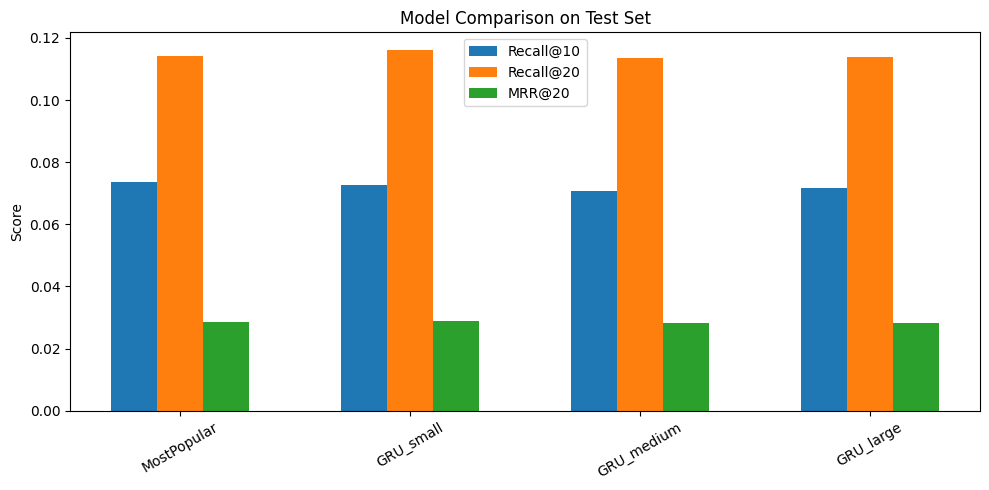

In [132]:
metric_cols = ["R@10", "R@20","MRR@10","MRR@20"] 

for col in metric_cols:
    final_results_with_baseline[col] = final_results_with_baseline[col].astype(float)

plt.figure(figsize=(10, 5))
x = np.arange(len(final_results_with_baseline))
width = 0.2

plt.bar(x - width, final_results_with_baseline["R@10"], width=width, label="Recall@10")
plt.bar(x,         final_results_with_baseline["R@20"], width=width, label="Recall@20")
plt.bar(x + width, final_results_with_baseline["MRR@20"], width=width, label="MRR@20")

plt.xticks(x, final_results_with_baseline["model"], rotation=30)
plt.ylabel("Score")
plt.title("Model Comparison on Test Set")
plt.legend()
plt.tight_layout()
plt.show()


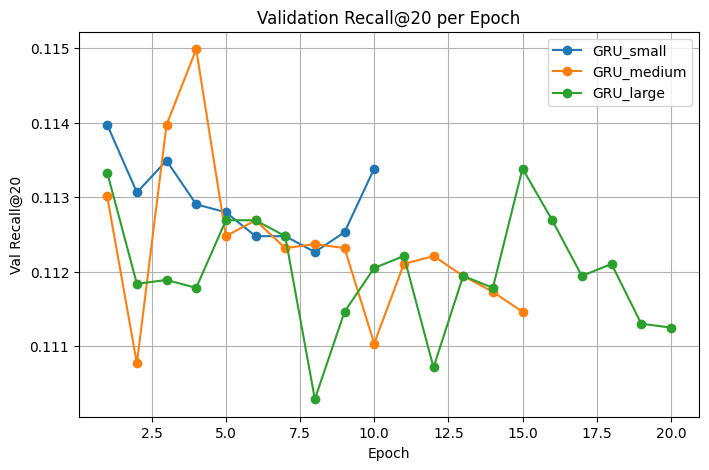

In [133]:
plt.figure(figsize=(8, 5))

for name, hist in all_histories.items():
    plt.plot(hist["epoch"], hist["val_recall@20"], marker="o", label=name)

plt.xlabel("Epoch")
plt.ylabel("Val Recall@20")
plt.title("Validation Recall@20 per Epoch")
plt.legend()
plt.grid(True)
plt.show()


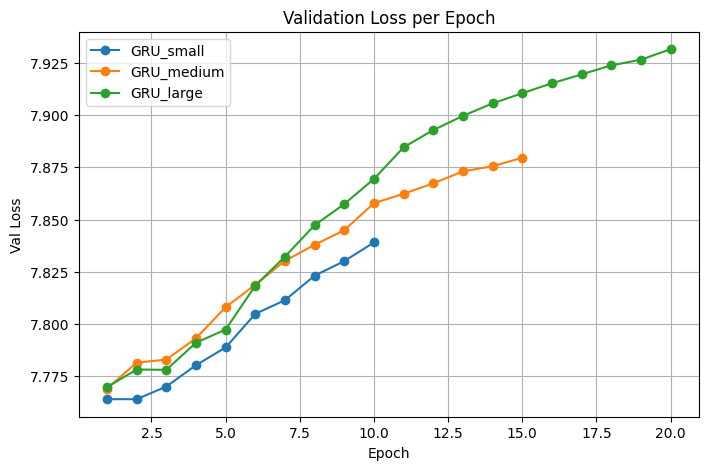

In [134]:
plt.figure(figsize=(8, 5))
for name, hist in all_histories.items():
    plt.plot(hist["epoch"], hist["val_loss"], marker="o", label=name)
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


The Resutlts are not so Good Due to several reasons including LOW number of Data

Change Model Type

In [160]:
import importlib
import src.models.sasrec as sasrec_mod

sasrec_mod = importlib.reload(sasrec_mod)

from src.models.sasrec import SASRec  # now from reloaded module


In [ ]:
import src.train_sasrec as train_sasrec_mod
train_sasrec_mod = importlib.reload(train_sasrec_mod)


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import numpy as np

from src.train_sasrec import train_sasrec, recall_mrr_at_k
from src.models.sasrec import SASRec

import sys
sys.path.append(str(Path().resolve()))
import src.models.sasrec as sasrec
importlib.reload(sasrec)

<module 'src.models.sasrec' from 'c:\\Users\\Mohammad\\Desktop\\Hands-On Projects\\Recommendation System\\Session-Based Sequential Recommender (GRU4Rec  Transformer)\\src\\models\\sasrec.py'>

In [163]:
X_train = np.load(DATA_DIR / "X_train.npy")
y_train = np.load(DATA_DIR / "y_train.npy")
L_train = np.load(DATA_DIR / "L_train.npy")

X_val = np.load(DATA_DIR / "X_val.npy")
y_val = np.load(DATA_DIR / "y_val.npy")
L_val = np.load(DATA_DIR / "L_val.npy")

X_test = np.load(DATA_DIR / "X_test.npy")
y_test = np.load(DATA_DIR / "y_test.npy")
L_test = np.load(DATA_DIR / "L_test.npy")

item2idx = np.load(DATA_DIR / "item2idx.npy", allow_pickle=True).item()
num_items = len(item2idx)
max_seq_len = X_train.shape[1]

print("Num items:", num_items, "Max seq len:", max_seq_len)

train_loader = create_dataloader(X_train, y_train, L_train, batch_size=256, shuffle=True)
val_loader   = create_dataloader(X_val,   y_val,   L_val,   batch_size=256, shuffle=False)
test_loader  = create_dataloader(X_test,  y_test,  L_test,  batch_size=256, shuffle=False)

Num items: 19411 Max seq len: 50


In [164]:
print("y_train min/max:", y_train.min(), y_train.max())
print("Any NaN in X_train:", np.isnan(X_train).any())
print("Any NaN in y_train:", np.isnan(y_train).any())

y_train min/max: 1 19411
Any NaN in X_train: False
Any NaN in y_train: False


In [165]:
sas_model = train_sasrec(
    data_dir=DATA_DIR,
    model_dir=Path("models"),
    batch_size=256,
    num_epochs=10, 
    lr=5e-4,
    weight_decay=1e-5,
    d_model=128,
    n_heads=4,
    n_layers=2,
    d_ff=512,
    dropout=0.2,
)

sas_recalls, sas_mrrs = recall_mrr_at_k(sas_model, test_loader, ks=(10, 20))
print("SASRec Test Recall:", sas_recalls)
print("SASRec Test MRR:", sas_mrrs)


Num items: 19411, max_seq_len: 50


[SASRec] Epoch 1/10: 100%|██████████| 586/586 [04:16<00:00,  2.29it/s, loss=6.9] 


[SASRec] Epoch 1: train_loss=6.9022, val_loss=5.6615, R@10=0.4178, R@20=0.4860, MRR@10=0.2363, MRR@20=0.2410
  -> Saved new best SASRec model


[SASRec] Epoch 2/10: 100%|██████████| 586/586 [04:06<00:00,  2.37it/s, loss=5.21]


[SASRec] Epoch 2: train_loss=5.2124, val_loss=4.9711, R@10=0.5343, R@20=0.6001, MRR@10=0.3195, MRR@20=0.3241
  -> Saved new best SASRec model


[SASRec] Epoch 3/10: 100%|██████████| 586/586 [04:04<00:00,  2.40it/s, loss=4.57]


[SASRec] Epoch 3: train_loss=4.5708, val_loss=4.7139, R@10=0.5714, R@20=0.6379, MRR@10=0.3453, MRR@20=0.3500
  -> Saved new best SASRec model


[SASRec] Epoch 4/10: 100%|██████████| 586/586 [04:06<00:00,  2.37it/s, loss=4.2] 


[SASRec] Epoch 4: train_loss=4.1987, val_loss=4.6217, R@10=0.5859, R@20=0.6512, MRR@10=0.3569, MRR@20=0.3615
  -> Saved new best SASRec model


[SASRec] Epoch 5/10: 100%|██████████| 586/586 [04:09<00:00,  2.35it/s, loss=3.95]


[SASRec] Epoch 5: train_loss=3.9496, val_loss=4.6118, R@10=0.5928, R@20=0.6619, MRR@10=0.3618, MRR@20=0.3666
  -> Saved new best SASRec model


[SASRec] Epoch 6/10: 100%|██████████| 586/586 [04:15<00:00,  2.30it/s, loss=3.7] 


[SASRec] Epoch 6: train_loss=3.7015, val_loss=4.5882, R@10=0.5997, R@20=0.6640, MRR@10=0.3677, MRR@20=0.3722
  -> Saved new best SASRec model


[SASRec] Epoch 7/10: 100%|██████████| 586/586 [04:13<00:00,  2.31it/s, loss=3.61]


[SASRec] Epoch 7: train_loss=3.6095, val_loss=4.6040, R@10=0.6037, R@20=0.6670, MRR@10=0.3686, MRR@20=0.3731


[SASRec] Epoch 8/10: 100%|██████████| 586/586 [04:13<00:00,  2.31it/s, loss=3.54]


[SASRec] Epoch 8: train_loss=3.5388, val_loss=4.6106, R@10=0.6029, R@20=0.6673, MRR@10=0.3697, MRR@20=0.3743


[SASRec] Epoch 9/10: 100%|██████████| 586/586 [04:12<00:00,  2.32it/s, loss=3.48]


[SASRec] Epoch 9: train_loss=3.4781, val_loss=4.6343, R@10=0.6039, R@20=0.6681, MRR@10=0.3703, MRR@20=0.3748


[SASRec] Epoch 10/10: 100%|██████████| 586/586 [04:09<00:00,  2.35it/s, loss=3.42]


[SASRec] Epoch 10: train_loss=3.4208, val_loss=4.6634, R@10=0.6028, R@20=0.6680, MRR@10=0.3703, MRR@20=0.3749
Training finished.
SASRec Test Recall: {10: 0.6031068168472749, 20: 0.6698873645438531}
SASRec Test MRR: {10: 0.37079589197909285, 20: 0.3754991784528913}


In [ ]:
# Fill with your actual logged GRU results
results = {
    "GRU_small":  {"R@10": 0.0718, "R@20": 0.1139, "MRR@20": 0.0298},
    "GRU_medium": {"R@10": 0.0731, "R@20": 0.1150, "MRR@20": 0.0299},
    "GRU_large":  {"R@10": 0.0727, "R@20": 0.1127, "MRR@20": 0.0298},
    "SASRec":     {"R@10": sas_recalls[10], "R@20": sas_recalls[20], "MRR@20": sas_mrrs[20]},
}

df_results = pd.DataFrame(results).T        
df_results


,R@10,R@20,MRR@20
GRU_small,0.071800,0.113900,0.029800
GRU_medium,0.073100,0.115000,0.029900
GRU_large,0.072700,0.112700,0.029800
SASRec,0.603107,0.669887,0.375499


In [211]:
# Convert dicts → scalar metrics
R10   = sas_recalls.get(10)
R20   = sas_recalls.get(20)
MRR10 = sas_mrrs.get(10)
MRR20 = sas_mrrs.get(20)

# Build  SASRec row
sas_row = pd.DataFrame([{
    "model": "SASRec",
    "R@10": f"{R10:.4f}",
    "R@20": f"{R20:.4f}",
    "MRR@10": f"{MRR10:.4f}",
    "MRR@20": f"{MRR20:.4f}"
}])

# Concat into results table
DF_RESULTS = pd.concat([final_results_df, sas_row], ignore_index=True)
DF_RESULTS
# df_results.set_index('model')
for col in DF_RESULTS.columns:
    DF_RESULTS[col] = pd.to_numeric(DF_RESULTS[col], errors="coerce")



In [212]:
DF_RESULTS

,model,R@10,R@20,MRR@10,MRR@20
0,NaN,0.07255,0.11600,0.02579,0.02874
1,NaN,0.07068,0.11354,0.02538,0.02832
2,NaN,0.07169,0.11397,0.02544,0.02831
3,NaN,0.60310,0.66990,0.37080,0.37550


<Figure size 1000x600 with 0 Axes>

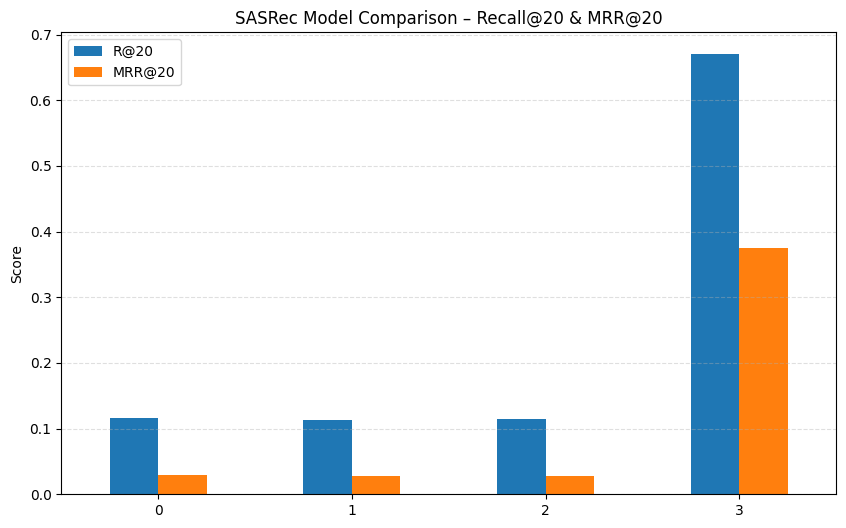

<Figure size 1000x600 with 0 Axes>

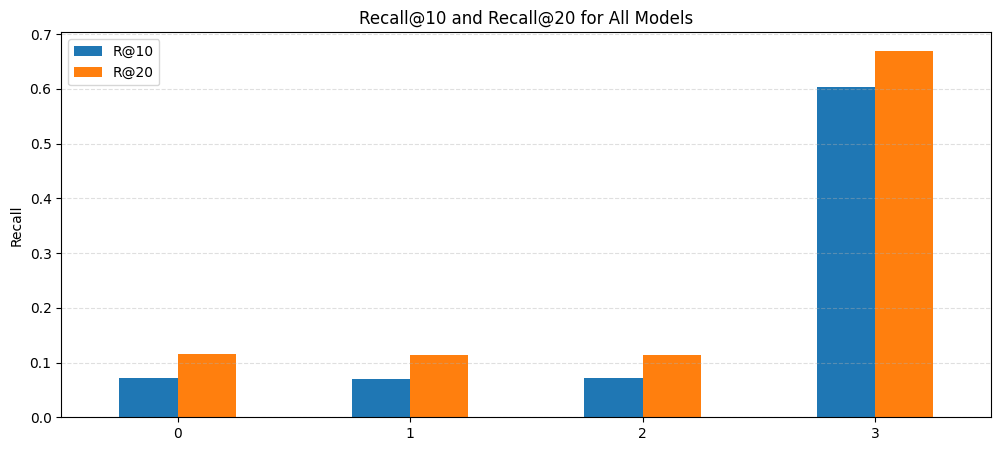

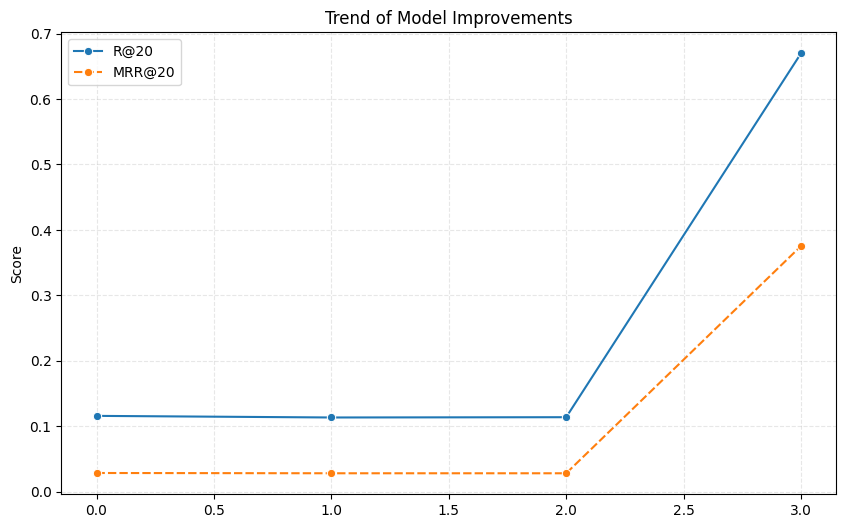

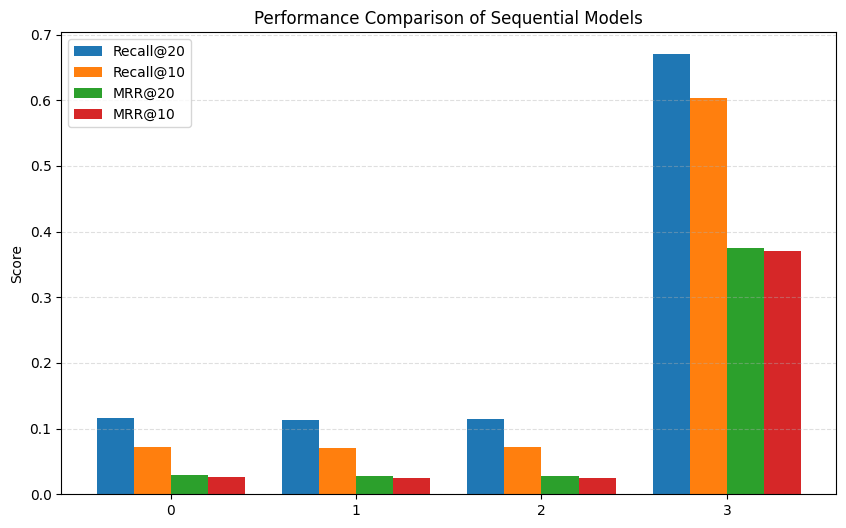

In [214]:
plt.figure(figsize=(10,6))
DF_RESULTS[["R@20", "MRR@20"]].plot(kind="bar", figsize=(10,6))
plt.title("SASRec Model Comparison – Recall@20 & MRR@20")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

plt.figure(figsize=(10,6))
DF_RESULTS[["R@10", "R@20"]].plot(kind="bar", figsize=(12,5), color=["#1f77b4","#ff7f0e"])
plt.title("Recall@10 and Recall@20 for All Models")
plt.ylabel("Recall")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=DF_RESULTS[["R@20", "MRR@20"]], marker="o")
plt.title("Trend of Model Improvements")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

plt.figure(figsize=(10,6))
x = range(len(DF_RESULTS))

plt.bar([i - 0.3 for i in x], DF_RESULTS["R@20"], width=0.2, label="Recall@20")
plt.bar([i-0.1 for i in x],                       DF_RESULTS["R@10"], width=0.2, label="Recall@10")
plt.bar([i + 0.1 for i in x], DF_RESULTS["MRR@20"], width=0.2, label="MRR@20")
plt.bar([i + 0.3 for i in x] ,DF_RESULTS["MRR@10"],width=0.2,label="MRR@10")
plt.xticks(x, DF_RESULTS.index, rotation=0)
plt.title("Performance Comparison of Sequential Models")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [210]:
DF_RESULTS.dtypes

model     object
R@10      object
R@20      object
MRR@10    object
MRR@20    object
dtype: object